# Coursework for MRI reconstruction (Autumn 2019)

In this tutorial, we provide the data loader to read and process the MRI data in order to ease the difficulty of training your network. By providing this, we hope you focus more on methodology development. Please feel free to change it to suit what you need.

In [25]:
#ALL IMPORTS
import h5py, os
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F

In [26]:
##### UNET MODEL ######

class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, relu activation and dropout.
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

    def __repr__(self):
        return f'ConvBlock(in_chans={self.in_chans}, out_chans={self.out_chans}, ' \
            f'drop_prob={self.drop_prob})'


class UnetModel(nn.Module):
    """
    PyTorch implementation of a U-Net model.

    This is based on:
        Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
        for biomedical image segmentation. In International Conference on Medical image
        computing and computer-assisted intervention, pages 234–241. Springer, 2015.
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob)]
            ch *= 2
        self.conv = ConvBlock(ch, ch, drop_prob)

        self.up_sample_layers = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_sample_layers += [ConvBlock(ch * 2, ch // 2, drop_prob)]
            ch //= 2
        self.up_sample_layers += [ConvBlock(ch * 2, ch, drop_prob)]
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch, ch // 2, kernel_size=1),
            nn.Conv2d(ch // 2, out_chans, kernel_size=1),
            nn.Conv2d(out_chans, out_chans, kernel_size=1),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.max_pool2d(output, kernel_size=2)

        output = self.conv(output)

        # Apply up-sampling layers
        for layer in self.up_sample_layers:
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
            output = torch.cat([output, stack.pop()], dim=1)
            output = layer(output)
        return self.conv2(output)

In [28]:
#pre-defined ultily functions used in creating the neural net

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
        
    return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm

class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)
    
    def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
    
    return data_list  
   
    from skimage.measure import compare_ssim 
    
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )  


def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [33]:
#Set initial path for the fullset of training data
file_path = '/data/local/NC2019MRI/train'

# Shuffle sets, and split train_index into train and validation 80:20 respectively 
numfiles_all = len(os.listdir(data_path_train))
print (numfiles_all)
indx = np.arange(numfiles_all)
np.random.shuffle(indx)

split_80_20 = 0.8 * numfiles_all
split_80_20 = int(split_80_20)
print(split_80_20)

np.random.seed(42)

train_inx = indx[:split_80_20]
val_inx = indx[split_80_20:]

print("train_inx",train_inx)
print("val_inx",val_inx)


70
56
train_inx [22  0 49  4 54 18 10 33 45 12 31  9 67  5 62 30 58 35 57 47 16 34 42 28
  7 53 40 44 46 19 56 39 25 38 13 50  3 17  8 55  6 36 64 69 68 15 27 41
 26 48 24 59 63 11 32 66]
val_inx [61 37 29 43 65  1 52 21  2 23 20 60 14 51]


In [34]:

    train_data_list = {}
    train_data_list['val']= [0] * len(val_inx)
    train_data_list['train'] = [0] * len(train_inx)
    count = 0  
    
    for fname in sorted(os.listdir(file_path)): 
        subject_path = os.path.join(file_path, fname)
        with h5py.File(subject_path,  "r") as hf:
             total_num_slices = hf['kspace'].shape[0]

                
        for i in range(len(train_inx)):
            if (train_inx[i] == count):
                train_data_list['train'][i] = (file_path+ "/" +fname, fname, total_num_slices)  
                break
                
        for k in range(len(val_inx)):
            if (val_inx[k] == count):
                train_data_list['val'][k] = (file_path+ "/"+ fname, fname, total_num_slices)
                break
        count = count +1

            
    train_data_final ={}         
    train_data_final['train'] = []  
    train_data_final['val'] = []  
           
    for i in range (len(train_data_list['train'])):
        for slice in range (5,train_data_list['train'][i][2]):
            train_data_final['train'].append((train_data_list['train'][i][1], train_data_list['train'][i][0], (slice)))
        

    for i in range (len(train_data_list['val'])):
        for slice in range (5,train_data_list['val'][i][2]):
            train_data_final['val'].append((train_data_list['val'][i][1], train_data_list['val'][i][0], slice))

            

In [35]:
print("VALIDATION SET")
valcount = 0
for i in range (len(train_data_final['val'])):
    print(" count : ",valcount,"  ", train_data_final['val'][i])
    valcount = valcount + 1
    
print("")
print("")
print("")
print("")

train_count = 0    
print("TRAIN SET")
for i in range (len(train_data_final['train'])):
    print(" count : ",train_count,"  ", train_data_final['train'][i])
    train_count = train_count + 1


VALIDATION SET
 count :  0    ('file1000660.h5', '/data/local/NC2019MRI/train/file1000660.h5', 5)
 count :  1    ('file1000660.h5', '/data/local/NC2019MRI/train/file1000660.h5', 6)
 count :  2    ('file1000660.h5', '/data/local/NC2019MRI/train/file1000660.h5', 7)
 count :  3    ('file1000660.h5', '/data/local/NC2019MRI/train/file1000660.h5', 8)
 count :  4    ('file1000660.h5', '/data/local/NC2019MRI/train/file1000660.h5', 9)
 count :  5    ('file1000660.h5', '/data/local/NC2019MRI/train/file1000660.h5', 10)
 count :  6    ('file1000660.h5', '/data/local/NC2019MRI/train/file1000660.h5', 11)
 count :  7    ('file1000660.h5', '/data/local/NC2019MRI/train/file1000660.h5', 12)
 count :  8    ('file1000660.h5', '/data/local/NC2019MRI/train/file1000660.h5', 13)
 count :  9    ('file1000660.h5', '/data/local/NC2019MRI/train/file1000660.h5', 14)
 count :  10    ('file1000660.h5', '/data/local/NC2019MRI/train/file1000660.h5', 15)
 count :  11    ('file1000660.h5', '/data/local/NC2019MRI/train/f

 count :  571    ('file1000628.h5', '/data/local/NC2019MRI/train/file1000628.h5', 26)
 count :  572    ('file1000628.h5', '/data/local/NC2019MRI/train/file1000628.h5', 27)
 count :  573    ('file1000628.h5', '/data/local/NC2019MRI/train/file1000628.h5', 28)
 count :  574    ('file1000628.h5', '/data/local/NC2019MRI/train/file1000628.h5', 29)
 count :  575    ('file1000628.h5', '/data/local/NC2019MRI/train/file1000628.h5', 30)
 count :  576    ('file1000628.h5', '/data/local/NC2019MRI/train/file1000628.h5', 31)
 count :  577    ('file1000628.h5', '/data/local/NC2019MRI/train/file1000628.h5', 32)
 count :  578    ('file1000628.h5', '/data/local/NC2019MRI/train/file1000628.h5', 33)
 count :  579    ('file1000628.h5', '/data/local/NC2019MRI/train/file1000628.h5', 34)
 count :  580    ('file1000628.h5', '/data/local/NC2019MRI/train/file1000628.h5', 35)
 count :  581    ('file1000480.h5', '/data/local/NC2019MRI/train/file1000480.h5', 5)
 count :  582    ('file1000480.h5', '/data/local/NC2019

 count :  1607    ('file1000702.h5', '/data/local/NC2019MRI/train/file1000702.h5', 35)
 count :  1608    ('file1000702.h5', '/data/local/NC2019MRI/train/file1000702.h5', 36)
 count :  1609    ('file1000702.h5', '/data/local/NC2019MRI/train/file1000702.h5', 37)
 count :  1610    ('file1000702.h5', '/data/local/NC2019MRI/train/file1000702.h5', 38)
 count :  1611    ('file1000702.h5', '/data/local/NC2019MRI/train/file1000702.h5', 39)
 count :  1612    ('file1000702.h5', '/data/local/NC2019MRI/train/file1000702.h5', 40)
 count :  1613    ('file1000702.h5', '/data/local/NC2019MRI/train/file1000702.h5', 41)
 count :  1614    ('file1000108.h5', '/data/local/NC2019MRI/train/file1000108.h5', 5)
 count :  1615    ('file1000108.h5', '/data/local/NC2019MRI/train/file1000108.h5', 6)
 count :  1616    ('file1000108.h5', '/data/local/NC2019MRI/train/file1000108.h5', 7)
 count :  1617    ('file1000108.h5', '/data/local/NC2019MRI/train/file1000108.h5', 8)
 count :  1618    ('file1000108.h5', '/data/loc

In [36]:
######loads_train_data #######
if __name__ == '__main__':
    
    acc = 8
    cen_fract = 0.04
    seed = False # random masks for each slice 
    num_workers = 12 
    
    #
    train_dataset = MRIDataset(train_data_final['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    
    validation_dataset = MRIDataset(train_data_final['val'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    validation_loader = DataLoader(validation_dataset, shuffle=True, batch_size=1, num_workers=num_workers)  
    

In [39]:
#cuda
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #'cpu'
torch.manual_seed(42)

# Now we can create a model
model = UnetModel(
    in_chans = 1,
    out_chans = 1,
    chans = 32,#640, #32
    num_pool_layers = 4,
    drop_prob = 0 ).to(device) # FirstModel().to(device)

# # we can also inspect its parameters
# print("Before training: \n", model.state_dict())

In [40]:
#set training


# set learning rate
print("HELOLOOO")
lr = 1e-1

#set number of epoches, i.e., number of times we iterate through the training set
epoches = 50 #100

# # We use mean square error (MSELoss)
loss_fn = nn.MSELoss(reduction='mean')

# # We also use stochastic gradient descent (SGD) to update a and b
optimiser = optim.SGD(model.parameters(), lr=lr)

count = 0 
train_loss_list = []
val_loss_list= []
loss_list= []
batch_sim = []
ssim_list = []
AV_batch_sim_list = []

for epoch in range(epoches):
   
    model.train()
    for data in train_loader:

        # set the model to training mode
        img_gt, img_und,_, _, _ = data
        
        volume_image_abs = T.complex_abs(img_gt) 
        cropped_gt = T.center_crop(volume_image_abs, [320, 320])#.to(device)
        cropped_gt = cropped_gt.view(1,1,320,320)
        
        volume_image_abs = T.complex_abs(img_und) 
        cropped_img_und = T.center_crop(volume_image_abs, [320, 320]).to(device)
        cropped_img_und = cropped_img_und.view(1,1,320,320)
        
        #model.zero_grad 
        img_gt.to(device) 
        img_und.to(device) 
        
        optimiser.zero_grad()
        y_pred = model(cropped_img_und.to(device))
        loss = loss_fn(cropped_gt.to(device), y_pred)
        loss.backward() 
        optimiser.step()
        count = count +1
        loss_list.append(loss)
        print ("count ", count, loss)
        
        A = cropped_img_und.squeeze().detach().cpu()
        C = cropped_gt.squeeze().squeeze().detach().cpu()
        B = y_pred.squeeze().squeeze().detach().cpu()
        all_imgs = torch.stack([A,B,C], dim=0)

        # from left to right: mask, masked kspace, undersampled image, ground truth
        plt.pause(1)
        
        ssim_value = ssim(C.unsqueeze(0).numpy(),B.unsqueeze(0).numpy())
        ssim_list.append(ssim_value)
      
        #calculate ssim
        batch_sim.append(ssim_value)
        
        
        if count == 0 or count % 10 == 1:
            total_SSIM_batch_val =0
            
            for batch_num in range (len(batch_sim)):
                total_SSIM_batch_val = total_SSIM_batch_val + batch_sim[batch_num]
                print("ssim", batch_sim[batch_num], "total_SSIM_batch_val", total_SSIM_batch_val)
            AV_batch_sim = total_SSIM_batch_val/10
            
            
            AV_batch_sim_list.append(AV_batch_sim)
            batch_sim.clear()
        
            print ("count :", count,"train_loss :",loss.item(),"train SSIM", ssim_value, "Batch_sim: ",AV_batch_sim)
            
        count = count +1

              
    with torch.no_grad():
        model.eval()
        for data in validation_loader:

            img_gt, img_und,_, _, _ = data
        
            volume_image_abs = T.complex_abs(img_gt) 
            cropped_gt = T.center_crop(volume_image_abs, [320, 320]).to(device)
            cropped_gt = cropped_gt.view(1,1,320,320).to(device)
        
            volume_image_abs = T.complex_abs(img_und) 
            cropped_img_und = T.center_crop(volume_image_abs, [320, 320]).to(device)
            cropped_img_und = cropped_img_und.view(1,1,320,320).to(device)
                
            optimiser.zero_grad()
            y_pred = model(cropped_img_und.to(device))
            val_loss = loss_fn(cropped_gt.to(device), y_pred)
            optimiser.step()
            val_loss_list.append(val_loss)
            
            print ("count :", count, "val_loss", val_loss.item())

     
 
                
            
        
#For a conv2D, input should be in (N, C, H, W) format.
#N is the number of samples/batch_size. C is the channels. H and W are height and width resp.

HELOLOOO
count  1 tensor(0.2100, device='cuda:0', grad_fn=<MeanBackward0>)


/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


ssim -0.0833414584407997 total_SSIM_batch_val -0.0833414584407997
count : 1 train_loss : 0.21000148355960846 train SSIM -0.0833414584407997 Batch_sim:  -0.00833414584407997
count  3 tensor(0.0848, device='cuda:0', grad_fn=<MeanBackward0>)
count  5 tensor(0.0202, device='cuda:0', grad_fn=<MeanBackward0>)
count  7 tensor(0.0198, device='cuda:0', grad_fn=<MeanBackward0>)
count  9 tensor(0.0420, device='cuda:0', grad_fn=<MeanBackward0>)
count  11 tensor(0.0328, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.05518670022160859 total_SSIM_batch_val 0.05518670022160859
ssim 0.16269505772825837 total_SSIM_batch_val 0.21788175794986697
ssim 0.3466397697744994 total_SSIM_batch_val 0.5645215277243664
ssim 0.13703667480203252 total_SSIM_batch_val 0.7015582025263989
ssim 0.15288060933700123 total_SSIM_batch_val 0.8544388118634001
count : 11 train_loss : 0.032767653465270996 train SSIM 0.15288060933700123 Batch_sim:  0.08544388118634001
count  13 tensor(0.0201, device='cuda:0', grad_fn=<MeanBackwar

count  115 tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>)
count  117 tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>)
count  119 tensor(0.0143, device='cuda:0', grad_fn=<MeanBackward0>)
count  121 tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.4905794034766985 total_SSIM_batch_val 0.4905794034766985
ssim 0.43542196214488044 total_SSIM_batch_val 0.9260013656215789
ssim 0.5117409704068739 total_SSIM_batch_val 1.4377423360284527
ssim 0.2501226440019607 total_SSIM_batch_val 1.6878649800304135
ssim 0.37505338972029945 total_SSIM_batch_val 2.062918369750713
count : 121 train_loss : 0.006057581398636103 train SSIM 0.37505338972029945 Batch_sim:  0.2062918369750713
count  123 tensor(0.0140, device='cuda:0', grad_fn=<MeanBackward0>)
count  125 tensor(0.0176, device='cuda:0', grad_fn=<MeanBackward0>)
count  127 tensor(0.0116, device='cuda:0', grad_fn=<MeanBackward0>)
count  129 tensor(0.0116, device='cuda:0', grad_fn=<MeanBackward0>)
count  131 tensor(0.0294, d

count  225 tensor(0.0110, device='cuda:0', grad_fn=<MeanBackward0>)
count  227 tensor(0.0160, device='cuda:0', grad_fn=<MeanBackward0>)
count  229 tensor(0.0190, device='cuda:0', grad_fn=<MeanBackward0>)
count  231 tensor(0.0192, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.17644074807520085 total_SSIM_batch_val 0.17644074807520085
ssim 0.3865202732800999 total_SSIM_batch_val 0.5629610213553008
ssim 0.3313484924540588 total_SSIM_batch_val 0.8943095138093595
ssim 0.3331122405544368 total_SSIM_batch_val 1.2274217543637964
ssim 0.43104550824604826 total_SSIM_batch_val 1.6584672626098447
count : 231 train_loss : 0.019213564693927765 train SSIM 0.43104550824604826 Batch_sim:  0.16584672626098446
count  233 tensor(0.0214, device='cuda:0', grad_fn=<MeanBackward0>)
count  235 tensor(0.0233, device='cuda:0', grad_fn=<MeanBackward0>)
count  237 tensor(0.0126, device='cuda:0', grad_fn=<MeanBackward0>)
count  239 tensor(0.0163, device='cuda:0', grad_fn=<MeanBackward0>)
count  241 tensor(0.0129

count  335 tensor(0.0160, device='cuda:0', grad_fn=<MeanBackward0>)
count  337 tensor(0.0138, device='cuda:0', grad_fn=<MeanBackward0>)
count  339 tensor(0.0319, device='cuda:0', grad_fn=<MeanBackward0>)
count  341 tensor(0.0183, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.5696094883390537 total_SSIM_batch_val 0.5696094883390537
ssim 0.47576099132732413 total_SSIM_batch_val 1.0453704796663779
ssim 0.39334380810241937 total_SSIM_batch_val 1.4387142877687973
ssim 0.2014474782648531 total_SSIM_batch_val 1.6401617660336503
ssim 0.36204995520712674 total_SSIM_batch_val 2.002211721240777
count : 341 train_loss : 0.018273843452334404 train SSIM 0.36204995520712674 Batch_sim:  0.2002211721240777
count  343 tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>)
count  345 tensor(0.0089, device='cuda:0', grad_fn=<MeanBackward0>)
count  347 tensor(0.0080, device='cuda:0', grad_fn=<MeanBackward0>)
count  349 tensor(0.0104, device='cuda:0', grad_fn=<MeanBackward0>)
count  351 tensor(0.0181, 

count  445 tensor(0.0278, device='cuda:0', grad_fn=<MeanBackward0>)
count  447 tensor(0.0164, device='cuda:0', grad_fn=<MeanBackward0>)
count  449 tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>)
count  451 tensor(0.0099, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.3261714505777182 total_SSIM_batch_val 0.3261714505777182
ssim 0.2548781609066511 total_SSIM_batch_val 0.5810496114843693
ssim 0.35772934984953547 total_SSIM_batch_val 0.9387789613339048
ssim 0.37249331912871947 total_SSIM_batch_val 1.3112722804626242
ssim 0.5124308385267026 total_SSIM_batch_val 1.823703118989327
count : 451 train_loss : 0.00989888422191143 train SSIM 0.5124308385267026 Batch_sim:  0.18237031189893269
count  453 tensor(0.0229, device='cuda:0', grad_fn=<MeanBackward0>)
count  455 tensor(0.0125, device='cuda:0', grad_fn=<MeanBackward0>)
count  457 tensor(0.0156, device='cuda:0', grad_fn=<MeanBackward0>)
count  459 tensor(0.0068, device='cuda:0', grad_fn=<MeanBackward0>)
count  461 tensor(0.0197, de

count  555 tensor(0.0126, device='cuda:0', grad_fn=<MeanBackward0>)
count  557 tensor(0.0166, device='cuda:0', grad_fn=<MeanBackward0>)
count  559 tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>)
count  561 tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.5329605271877222 total_SSIM_batch_val 0.5329605271877222
ssim 0.3558803005314395 total_SSIM_batch_val 0.8888408277191617
ssim 0.3817392658187652 total_SSIM_batch_val 1.270580093537927
ssim 0.4898777768862107 total_SSIM_batch_val 1.7604578704241378
ssim 0.2918784449272613 total_SSIM_batch_val 2.052336315351399
count : 561 train_loss : 0.023952340707182884 train SSIM 0.2918784449272613 Batch_sim:  0.2052336315351399
count  563 tensor(0.0088, device='cuda:0', grad_fn=<MeanBackward0>)
count  565 tensor(0.0094, device='cuda:0', grad_fn=<MeanBackward0>)
count  567 tensor(0.0146, device='cuda:0', grad_fn=<MeanBackward0>)
count  569 tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>)
count  571 tensor(0.0104, devic

count  665 tensor(0.0188, device='cuda:0', grad_fn=<MeanBackward0>)
count  667 tensor(0.0086, device='cuda:0', grad_fn=<MeanBackward0>)
count  669 tensor(0.0110, device='cuda:0', grad_fn=<MeanBackward0>)
count  671 tensor(0.0093, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.3490735511638717 total_SSIM_batch_val 0.3490735511638717
ssim 0.39469679534864693 total_SSIM_batch_val 0.7437703465125186
ssim 0.4435669267952159 total_SSIM_batch_val 1.1873372733077345
ssim 0.35251941475357096 total_SSIM_batch_val 1.5398566880613056
ssim 0.5152281779634468 total_SSIM_batch_val 2.0550848660247523
count : 671 train_loss : 0.009323274716734886 train SSIM 0.5152281779634468 Batch_sim:  0.20550848660247523
count  673 tensor(0.0158, device='cuda:0', grad_fn=<MeanBackward0>)
count  675 tensor(0.0102, device='cuda:0', grad_fn=<MeanBackward0>)
count  677 tensor(0.0105, device='cuda:0', grad_fn=<MeanBackward0>)
count  679 tensor(0.0126, device='cuda:0', grad_fn=<MeanBackward0>)
count  681 tensor(0.0152, 

count  775 tensor(0.0158, device='cuda:0', grad_fn=<MeanBackward0>)
count  777 tensor(0.0153, device='cuda:0', grad_fn=<MeanBackward0>)
count  779 tensor(0.0105, device='cuda:0', grad_fn=<MeanBackward0>)
count  781 tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.5456439556658951 total_SSIM_batch_val 0.5456439556658951
ssim 0.4122029178492117 total_SSIM_batch_val 0.9578468735151068
ssim 0.37389945142589465 total_SSIM_batch_val 1.3317463249410015
ssim 0.48369028956158405 total_SSIM_batch_val 1.8154366145025855
ssim 0.39232948337157686 total_SSIM_batch_val 2.2077660978741624
count : 781 train_loss : 0.008234905079007149 train SSIM 0.39232948337157686 Batch_sim:  0.22077660978741626
count  783 tensor(0.0117, device='cuda:0', grad_fn=<MeanBackward0>)
count  785 tensor(0.0194, device='cuda:0', grad_fn=<MeanBackward0>)
count  787 tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>)
count  789 tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>)
count  791 tensor(0.0103

count  885 tensor(0.0149, device='cuda:0', grad_fn=<MeanBackward0>)
count  887 tensor(0.0095, device='cuda:0', grad_fn=<MeanBackward0>)
count  889 tensor(0.0083, device='cuda:0', grad_fn=<MeanBackward0>)
count  891 tensor(0.0128, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.25578031342501834 total_SSIM_batch_val 0.25578031342501834
ssim 0.39168911821842434 total_SSIM_batch_val 0.6474694316434426
ssim 0.47860250857676967 total_SSIM_batch_val 1.1260719402202124
ssim 0.46072968938531156 total_SSIM_batch_val 1.586801629605524
ssim 0.4823206145204263 total_SSIM_batch_val 2.0691222441259502
count : 891 train_loss : 0.012804205529391766 train SSIM 0.4823206145204263 Batch_sim:  0.20691222441259502
count  893 tensor(0.0073, device='cuda:0', grad_fn=<MeanBackward0>)
count  895 tensor(0.0095, device='cuda:0', grad_fn=<MeanBackward0>)
count  897 tensor(0.0331, device='cuda:0', grad_fn=<MeanBackward0>)
count  899 tensor(0.0170, device='cuda:0', grad_fn=<MeanBackward0>)
count  901 tensor(0.0175

count  995 tensor(0.0191, device='cuda:0', grad_fn=<MeanBackward0>)
count  997 tensor(0.0067, device='cuda:0', grad_fn=<MeanBackward0>)
count  999 tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>)
count  1001 tensor(0.0154, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.5328992446521057 total_SSIM_batch_val 0.5328992446521057
ssim 0.3910572576423262 total_SSIM_batch_val 0.9239565022944318
ssim 0.449355075947366 total_SSIM_batch_val 1.3733115782417977
ssim 0.44029741498536495 total_SSIM_batch_val 1.8136089932271626
ssim 0.26176142842538275 total_SSIM_batch_val 2.0753704216525453
count : 1001 train_loss : 0.015395407564938068 train SSIM 0.26176142842538275 Batch_sim:  0.20753704216525454
count  1003 tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>)
count  1005 tensor(0.0154, device='cuda:0', grad_fn=<MeanBackward0>)
count  1007 tensor(0.0048, device='cuda:0', grad_fn=<MeanBackward0>)
count  1009 tensor(0.0166, device='cuda:0', grad_fn=<MeanBackward0>)
count  1011 tensor(0

count  1105 tensor(0.0196, device='cuda:0', grad_fn=<MeanBackward0>)
count  1107 tensor(0.0091, device='cuda:0', grad_fn=<MeanBackward0>)
count  1109 tensor(0.0390, device='cuda:0', grad_fn=<MeanBackward0>)
count  1111 tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.39777371613666135 total_SSIM_batch_val 0.39777371613666135
ssim 0.3560383462354938 total_SSIM_batch_val 0.7538120623721551
ssim 0.548648613932269 total_SSIM_batch_val 1.3024606763044242
ssim 0.19257702079914849 total_SSIM_batch_val 1.4950376971035726
ssim 0.5955577197837073 total_SSIM_batch_val 2.09059541688728
count : 1111 train_loss : 0.008421418257057667 train SSIM 0.5955577197837073 Batch_sim:  0.20905954168872798
count  1113 tensor(0.0139, device='cuda:0', grad_fn=<MeanBackward0>)
count  1115 tensor(0.0166, device='cuda:0', grad_fn=<MeanBackward0>)
count  1117 tensor(0.0039, device='cuda:0', grad_fn=<MeanBackward0>)
count  1119 tensor(0.0031, device='cuda:0', grad_fn=<MeanBackward0>)
count  1121 tensor(

count  1215 tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>)
count  1217 tensor(0.0143, device='cuda:0', grad_fn=<MeanBackward0>)
count  1219 tensor(0.0183, device='cuda:0', grad_fn=<MeanBackward0>)
count  1221 tensor(0.0164, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.4962816976363548 total_SSIM_batch_val 0.4962816976363548
ssim 0.46732558270928787 total_SSIM_batch_val 0.9636072803456427
ssim 0.4381213889590054 total_SSIM_batch_val 1.401728669304648
ssim 0.603046602939207 total_SSIM_batch_val 2.004775272243855
ssim 0.4195491790280051 total_SSIM_batch_val 2.4243244512718602
count : 1221 train_loss : 0.016367752104997635 train SSIM 0.4195491790280051 Batch_sim:  0.24243244512718604
count  1223 tensor(0.0232, device='cuda:0', grad_fn=<MeanBackward0>)
count  1225 tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>)
count  1227 tensor(0.0046, device='cuda:0', grad_fn=<MeanBackward0>)
count  1229 tensor(0.0163, device='cuda:0', grad_fn=<MeanBackward0>)
count  1231 tensor(0.

count  1325 tensor(0.0088, device='cuda:0', grad_fn=<MeanBackward0>)
count  1327 tensor(0.0465, device='cuda:0', grad_fn=<MeanBackward0>)
count  1329 tensor(0.0088, device='cuda:0', grad_fn=<MeanBackward0>)
count  1331 tensor(0.0070, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.6208144515771102 total_SSIM_batch_val 0.6208144515771102
ssim 0.38284890930042315 total_SSIM_batch_val 1.0036633608775334
ssim 0.26031849651970157 total_SSIM_batch_val 1.263981857397235
ssim 0.6304192278860211 total_SSIM_batch_val 1.8944010852832562
ssim 0.5255635904428976 total_SSIM_batch_val 2.419964675726154
count : 1331 train_loss : 0.00702797994017601 train SSIM 0.5255635904428976 Batch_sim:  0.2419964675726154
count  1333 tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>)
count  1335 tensor(0.0115, device='cuda:0', grad_fn=<MeanBackward0>)
count  1337 tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
count  1339 tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>)
count  1341 tensor(0.

count  1435 tensor(0.0219, device='cuda:0', grad_fn=<MeanBackward0>)
count  1437 tensor(0.0086, device='cuda:0', grad_fn=<MeanBackward0>)
count  1439 tensor(0.0098, device='cuda:0', grad_fn=<MeanBackward0>)
count  1441 tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.6095314996513675 total_SSIM_batch_val 0.6095314996513675
ssim 0.2866616619338874 total_SSIM_batch_val 0.896193161585255
ssim 0.3965321985874574 total_SSIM_batch_val 1.2927253601727124
ssim 0.3564962008549532 total_SSIM_batch_val 1.6492215610276657
ssim 0.4548063366176702 total_SSIM_batch_val 2.104027897645336
count : 1441 train_loss : 0.010737268254160881 train SSIM 0.4548063366176702 Batch_sim:  0.2104027897645336
count  1443 tensor(0.0146, device='cuda:0', grad_fn=<MeanBackward0>)
count  1445 tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)
count  1447 tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward0>)
count  1449 tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>)
count  1451 tensor(0.0

count  1545 tensor(0.0099, device='cuda:0', grad_fn=<MeanBackward0>)
count  1547 tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>)
count  1549 tensor(0.0360, device='cuda:0', grad_fn=<MeanBackward0>)
count  1551 tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.4465556473448821 total_SSIM_batch_val 0.4465556473448821
ssim 0.35043284739060576 total_SSIM_batch_val 0.7969884947354879
ssim 0.5961168050650487 total_SSIM_batch_val 1.3931052998005367
ssim 0.27066924708972345 total_SSIM_batch_val 1.66377454689026
ssim 0.5540307284882943 total_SSIM_batch_val 2.2178052753785544
count : 1551 train_loss : 0.005941343028098345 train SSIM 0.5540307284882943 Batch_sim:  0.22178052753785543
count  1553 tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
count  1555 tensor(0.0164, device='cuda:0', grad_fn=<MeanBackward0>)
count  1557 tensor(0.0071, device='cuda:0', grad_fn=<MeanBackward0>)
count  1559 tensor(0.0118, device='cuda:0', grad_fn=<MeanBackward0>)
count  1561 tensor(

count  1655 tensor(0.0114, device='cuda:0', grad_fn=<MeanBackward0>)
count  1657 tensor(0.0143, device='cuda:0', grad_fn=<MeanBackward0>)
count  1659 tensor(0.0102, device='cuda:0', grad_fn=<MeanBackward0>)
count  1661 tensor(0.0048, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.6615964728468817 total_SSIM_batch_val 0.6615964728468817
ssim 0.39501293549630195 total_SSIM_batch_val 1.0566094083431836
ssim 0.49511906808729234 total_SSIM_batch_val 1.551728476430476
ssim 0.33729470463496175 total_SSIM_batch_val 1.8890231810654377
ssim 0.4300404424069661 total_SSIM_batch_val 2.319063623472404
count : 1661 train_loss : 0.004845720250159502 train SSIM 0.4300404424069661 Batch_sim:  0.23190636234724038
count  1663 tensor(0.0161, device='cuda:0', grad_fn=<MeanBackward0>)
count  1665 tensor(0.0146, device='cuda:0', grad_fn=<MeanBackward0>)
count  1667 tensor(0.0126, device='cuda:0', grad_fn=<MeanBackward0>)
count  1669 tensor(0.0386, device='cuda:0', grad_fn=<MeanBackward0>)
count  1671 tensor

count  1765 tensor(0.0132, device='cuda:0', grad_fn=<MeanBackward0>)
count  1767 tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>)
count  1769 tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
count  1771 tensor(0.0087, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.6283153672933103 total_SSIM_batch_val 0.6283153672933103
ssim 0.43742946849541176 total_SSIM_batch_val 1.065744835788722
ssim 0.3837803978574746 total_SSIM_batch_val 1.4495252336461966
ssim 0.666623131832794 total_SSIM_batch_val 2.1161483654789905
ssim 0.5372012638604399 total_SSIM_batch_val 2.6533496293394303
count : 1771 train_loss : 0.008721739985048771 train SSIM 0.5372012638604399 Batch_sim:  0.26533496293394304
count  1773 tensor(0.0090, device='cuda:0', grad_fn=<MeanBackward0>)
count  1775 tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)
count  1777 tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>)
count  1779 tensor(0.0066, device='cuda:0', grad_fn=<MeanBackward0>)
count  1781 tensor(0

count  1875 tensor(0.0157, device='cuda:0', grad_fn=<MeanBackward0>)
count  1877 tensor(0.0079, device='cuda:0', grad_fn=<MeanBackward0>)
count  1879 tensor(0.0134, device='cuda:0', grad_fn=<MeanBackward0>)
count  1881 tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.264729244095431 total_SSIM_batch_val 0.264729244095431
ssim 0.3938388345364041 total_SSIM_batch_val 0.6585680786318351
ssim 0.5034249873679454 total_SSIM_batch_val 1.1619930659997806
ssim 0.43993256431123284 total_SSIM_batch_val 1.6019256303110134
ssim 0.3800479851642783 total_SSIM_batch_val 1.9819736154752916
count : 1881 train_loss : 0.010709702968597412 train SSIM 0.3800479851642783 Batch_sim:  0.19819736154752915
count  1883 tensor(0.0083, device='cuda:0', grad_fn=<MeanBackward0>)
count  1885 tensor(0.0125, device='cuda:0', grad_fn=<MeanBackward0>)
count  1887 tensor(0.0046, device='cuda:0', grad_fn=<MeanBackward0>)
count  1889 tensor(0.0096, device='cuda:0', grad_fn=<MeanBackward0>)
count  1891 tensor(0

count  1985 tensor(0.0181, device='cuda:0', grad_fn=<MeanBackward0>)
count  1987 tensor(0.0134, device='cuda:0', grad_fn=<MeanBackward0>)
count  1989 tensor(0.0042, device='cuda:0', grad_fn=<MeanBackward0>)
count  1991 tensor(0.0045, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.635937804320353 total_SSIM_batch_val 0.635937804320353
ssim 0.3977709088405452 total_SSIM_batch_val 1.0337087131608982
ssim 0.5293274469724365 total_SSIM_batch_val 1.5630361601333347
ssim 0.6692302646116616 total_SSIM_batch_val 2.232266424744996
ssim 0.5400683818006827 total_SSIM_batch_val 2.772334806545679
count : 1991 train_loss : 0.00448464322835207 train SSIM 0.5400683818006827 Batch_sim:  0.2772334806545679
count  1993 tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>)
count  1995 tensor(0.0035, device='cuda:0', grad_fn=<MeanBackward0>)
count  1997 tensor(0.0179, device='cuda:0', grad_fn=<MeanBackward0>)
count  1999 tensor(0.0083, device='cuda:0', grad_fn=<MeanBackward0>)
count  2001 tensor(0.0060

count  2095 tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>)
count  2097 tensor(0.0132, device='cuda:0', grad_fn=<MeanBackward0>)
count  2099 tensor(0.0161, device='cuda:0', grad_fn=<MeanBackward0>)
count  2101 tensor(0.0116, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.4705758674251241 total_SSIM_batch_val 0.4705758674251241
ssim 0.5499050339334701 total_SSIM_batch_val 1.0204809013585943
ssim 0.5805327430509719 total_SSIM_batch_val 1.6010136444095662
ssim 0.25902013487495984 total_SSIM_batch_val 1.860033779284526
ssim 0.38641565475779777 total_SSIM_batch_val 2.246449434042324
count : 2101 train_loss : 0.01157559733837843 train SSIM 0.38641565475779777 Batch_sim:  0.2246449434042324
count  2103 tensor(0.0079, device='cuda:0', grad_fn=<MeanBackward0>)
count  2105 tensor(0.0075, device='cuda:0', grad_fn=<MeanBackward0>)
count  2107 tensor(0.0067, device='cuda:0', grad_fn=<MeanBackward0>)
count  2109 tensor(0.0101, device='cuda:0', grad_fn=<MeanBackward0>)
count  2111 tensor(0

count  2205 tensor(0.0075, device='cuda:0', grad_fn=<MeanBackward0>)
count  2207 tensor(0.0141, device='cuda:0', grad_fn=<MeanBackward0>)
count  2209 tensor(0.0100, device='cuda:0', grad_fn=<MeanBackward0>)
count  2211 tensor(0.0046, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.423461775717299 total_SSIM_batch_val 0.423461775717299
ssim 0.5328411913607517 total_SSIM_batch_val 0.9563029670780507
ssim 0.28470832963473 total_SSIM_batch_val 1.2410112967127807
ssim 0.4175951017831505 total_SSIM_batch_val 1.6586063984959312
ssim 0.6180185511126183 total_SSIM_batch_val 2.2766249496085496
count : 2211 train_loss : 0.004639314487576485 train SSIM 0.6180185511126183 Batch_sim:  0.22766249496085494
count  2213 tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>)
count  2215 tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>)
count  2217 tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>)
count  2219 tensor(0.0131, device='cuda:0', grad_fn=<MeanBackward0>)
count  2221 tensor(0.00

count  2315 tensor(0.0091, device='cuda:0', grad_fn=<MeanBackward0>)
count  2317 tensor(0.0147, device='cuda:0', grad_fn=<MeanBackward0>)
count  2319 tensor(0.0090, device='cuda:0', grad_fn=<MeanBackward0>)
count  2321 tensor(0.0200, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.3040766367102424 total_SSIM_batch_val 0.3040766367102424
ssim 0.5165288970992451 total_SSIM_batch_val 0.8206055338094875
ssim 0.5416434754882515 total_SSIM_batch_val 1.362249009297739
ssim 0.44313964430103225 total_SSIM_batch_val 1.8053886535987713
ssim 0.3255212205623039 total_SSIM_batch_val 2.130909874161075
count : 2321 train_loss : 0.01996120624244213 train SSIM 0.3255212205623039 Batch_sim:  0.2130909874161075
count  2323 tensor(0.0090, device='cuda:0', grad_fn=<MeanBackward0>)
count  2325 tensor(0.0099, device='cuda:0', grad_fn=<MeanBackward0>)
count  2327 tensor(0.0073, device='cuda:0', grad_fn=<MeanBackward0>)
count  2329 tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>)
count  2331 tensor(0.0

count  2425 tensor(0.0093, device='cuda:0', grad_fn=<MeanBackward0>)
count  2427 tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward0>)
count  2429 tensor(0.0204, device='cuda:0', grad_fn=<MeanBackward0>)
count  2431 tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.4021931894562379 total_SSIM_batch_val 0.4021931894562379
ssim 0.5804215907578054 total_SSIM_batch_val 0.9826147802140432
ssim 0.5949175763984869 total_SSIM_batch_val 1.57753235661253
ssim 0.2607733119439975 total_SSIM_batch_val 1.8383056685565276
ssim 0.39179258128142813 total_SSIM_batch_val 2.2300982498379556
count : 2431 train_loss : 0.008515841327607632 train SSIM 0.39179258128142813 Batch_sim:  0.22300982498379557
count  2433 tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>)
count  2435 tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>)
count  2437 tensor(0.0170, device='cuda:0', grad_fn=<MeanBackward0>)
count  2439 tensor(0.0127, device='cuda:0', grad_fn=<MeanBackward0>)
count  2441 tensor(

count  2535 tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward0>)
count  2537 tensor(0.0131, device='cuda:0', grad_fn=<MeanBackward0>)
count  2539 tensor(0.0046, device='cuda:0', grad_fn=<MeanBackward0>)
count  2541 tensor(0.0081, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.38953425001177944 total_SSIM_batch_val 0.38953425001177944
ssim 0.5213760881535205 total_SSIM_batch_val 0.9109103381653
ssim 0.45261627729313214 total_SSIM_batch_val 1.363526615458432
ssim 0.5818647315840036 total_SSIM_batch_val 1.9453913470424355
ssim 0.5368252483811925 total_SSIM_batch_val 2.482216595423628
count : 2541 train_loss : 0.008053810335695744 train SSIM 0.5368252483811925 Batch_sim:  0.2482216595423628
count  2543 tensor(0.0079, device='cuda:0', grad_fn=<MeanBackward0>)
count  2545 tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>)
count  2547 tensor(0.0123, device='cuda:0', grad_fn=<MeanBackward0>)
count  2549 tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>)
count  2551 tensor(0.0

count  2645 tensor(0.0130, device='cuda:0', grad_fn=<MeanBackward0>)
count  2647 tensor(0.0044, device='cuda:0', grad_fn=<MeanBackward0>)
count  2649 tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>)
count  2651 tensor(0.0108, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.3546855990609865 total_SSIM_batch_val 0.3546855990609865
ssim 0.513224107693787 total_SSIM_batch_val 0.8679097067547735
ssim 0.6189896050079413 total_SSIM_batch_val 1.486899311762715
ssim 0.5150562496504831 total_SSIM_batch_val 2.0019555614131983
ssim 0.27587907223077157 total_SSIM_batch_val 2.2778346336439697
count : 2651 train_loss : 0.010833424516022205 train SSIM 0.27587907223077157 Batch_sim:  0.22778346336439698
count  2653 tensor(0.0138, device='cuda:0', grad_fn=<MeanBackward0>)
count  2655 tensor(0.0094, device='cuda:0', grad_fn=<MeanBackward0>)
count  2657 tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>)
count  2659 tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>)
count  2661 tensor(

count  2755 tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward0>)
count  2757 tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>)
count  2759 tensor(0.0091, device='cuda:0', grad_fn=<MeanBackward0>)
count  2761 tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.44655925549002684 total_SSIM_batch_val 0.44655925549002684
ssim 0.48719947710756034 total_SSIM_batch_val 0.9337587325975871
ssim 0.42747586681007416 total_SSIM_batch_val 1.3612345994076613
ssim 0.3327012265711048 total_SSIM_batch_val 1.693935825978766
ssim 0.48611312706458515 total_SSIM_batch_val 2.180048953043351
count : 2761 train_loss : 0.006160121876746416 train SSIM 0.48611312706458515 Batch_sim:  0.21800489530433512
count  2763 tensor(0.0043, device='cuda:0', grad_fn=<MeanBackward0>)
count  2765 tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
count  2767 tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>)
count  2769 tensor(0.0058, device='cuda:0', grad_fn=<MeanBackward0>)
count  2771 ten

count  2865 tensor(0.0097, device='cuda:0', grad_fn=<MeanBackward0>)
count  2867 tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>)
count  2869 tensor(0.0070, device='cuda:0', grad_fn=<MeanBackward0>)
count  2871 tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.4521508202825418 total_SSIM_batch_val 0.4521508202825418
ssim 0.3914286869394293 total_SSIM_batch_val 0.8435795072219711
ssim 0.34928241423374323 total_SSIM_batch_val 1.1928619214557143
ssim 0.5705877411037484 total_SSIM_batch_val 1.763449662559463
ssim 0.4555085012432626 total_SSIM_batch_val 2.2189581638027254
count : 2871 train_loss : 0.008360481821000576 train SSIM 0.4555085012432626 Batch_sim:  0.22189581638027253
count  2873 tensor(0.0093, device='cuda:0', grad_fn=<MeanBackward0>)
count  2875 tensor(0.0112, device='cuda:0', grad_fn=<MeanBackward0>)
count  2877 tensor(0.0102, device='cuda:0', grad_fn=<MeanBackward0>)
count  2879 tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
count  2881 tensor(

count  2975 tensor(0.0142, device='cuda:0', grad_fn=<MeanBackward0>)
count  2977 tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
count  2979 tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>)
count  2981 tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.39109799544282725 total_SSIM_batch_val 0.39109799544282725
ssim 0.3839384249497218 total_SSIM_batch_val 0.775036420392549
ssim 0.49163251925336526 total_SSIM_batch_val 1.2666689396459143
ssim 0.5571010359363214 total_SSIM_batch_val 1.8237699755822359
ssim 0.588131111620826 total_SSIM_batch_val 2.411901087203062
count : 2981 train_loss : 0.009184170514345169 train SSIM 0.588131111620826 Batch_sim:  0.2411901087203062
count  2983 tensor(0.0183, device='cuda:0', grad_fn=<MeanBackward0>)
count  2985 tensor(0.0089, device='cuda:0', grad_fn=<MeanBackward0>)
count  2987 tensor(0.0105, device='cuda:0', grad_fn=<MeanBackward0>)
count  2989 tensor(0.0157, device='cuda:0', grad_fn=<MeanBackward0>)
count  2991 tensor(0.

count  3085 tensor(0.0269, device='cuda:0', grad_fn=<MeanBackward0>)
count  3087 tensor(0.0121, device='cuda:0', grad_fn=<MeanBackward0>)
count  3089 tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward0>)
count  3091 tensor(0.0035, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.5355755009913143 total_SSIM_batch_val 0.5355755009913143
ssim 0.2723829480689079 total_SSIM_batch_val 0.8079584490602223
ssim 0.34736287791670695 total_SSIM_batch_val 1.1553213269769294
ssim 0.632072545333049 total_SSIM_batch_val 1.7873938723099783
ssim 0.5793740683594354 total_SSIM_batch_val 2.3667679406694138
count : 3091 train_loss : 0.0034858863800764084 train SSIM 0.5793740683594354 Batch_sim:  0.23667679406694137
count  3093 tensor(0.0165, device='cuda:0', grad_fn=<MeanBackward0>)
count  3095 tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
count  3097 tensor(0.0099, device='cuda:0', grad_fn=<MeanBackward0>)
count  3099 tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>)
count  3101 tensor

count  3195 tensor(0.0159, device='cuda:0', grad_fn=<MeanBackward0>)
count  3197 tensor(0.0153, device='cuda:0', grad_fn=<MeanBackward0>)
count  3199 tensor(0.0393, device='cuda:0', grad_fn=<MeanBackward0>)
count  3201 tensor(0.0115, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.3962504837479124 total_SSIM_batch_val 0.3962504837479124
ssim 0.2958429761200056 total_SSIM_batch_val 0.692093459867918
ssim 0.43331197671765387 total_SSIM_batch_val 1.125405436585572
ssim 0.245443964427174 total_SSIM_batch_val 1.3708494010127459
ssim 0.40337659977982754 total_SSIM_batch_val 1.7742260007925734
count : 3201 train_loss : 0.011531037278473377 train SSIM 0.40337659977982754 Batch_sim:  0.17742260007925734
count  3203 tensor(0.0185, device='cuda:0', grad_fn=<MeanBackward0>)
count  3205 tensor(0.0177, device='cuda:0', grad_fn=<MeanBackward0>)
count  3207 tensor(0.0146, device='cuda:0', grad_fn=<MeanBackward0>)
count  3209 tensor(0.0072, device='cuda:0', grad_fn=<MeanBackward0>)
count  3211 tensor(

count  3305 tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
count  3307 tensor(0.0067, device='cuda:0', grad_fn=<MeanBackward0>)
count  3309 tensor(0.0073, device='cuda:0', grad_fn=<MeanBackward0>)
count  3311 tensor(0.0099, device='cuda:0', grad_fn=<MeanBackward0>)
ssim 0.5356994618032322 total_SSIM_batch_val 0.5356994618032322
ssim 0.4155305962432591 total_SSIM_batch_val 0.9512300580464914
ssim 0.3672446472648989 total_SSIM_batch_val 1.3184747053113903
ssim 0.3445173485911945 total_SSIM_batch_val 1.6629920539025849
ssim 0.6710135006052804 total_SSIM_batch_val 2.3340055545078653
count : 3311 train_loss : 0.009925405494868755 train SSIM 0.6710135006052804 Batch_sim:  0.23340055545078653
count  3313 tensor(0.0072, device='cuda:0', grad_fn=<MeanBackward0>)
count  3315 tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>)
count  3317 tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>)
count  3319 tensor(0.0123, device='cuda:0', grad_fn=<MeanBackward0>)
count  3321 tensor(

count : 3398 val_loss 0.014268407598137856
count : 3398 val_loss 0.007595717441290617
count : 3398 val_loss 0.030086422339081764
count : 3398 val_loss 0.007907954044640064
count : 3398 val_loss 0.01999891735613346
count : 3398 val_loss 0.00885525532066822
count : 3398 val_loss 0.007304457947611809
count : 3398 val_loss 0.01979258842766285
count : 3398 val_loss 0.006521550472825766
count : 3398 val_loss 0.03119371458888054
count : 3398 val_loss 0.0062972623854875565
count : 3398 val_loss 0.013580583035945892
count : 3398 val_loss 0.008679710328578949
count : 3398 val_loss 0.009281831793487072
count : 3398 val_loss 0.009155419655144215
count : 3398 val_loss 0.01123346108943224
count : 3398 val_loss 0.007219451479613781
count : 3398 val_loss 0.005372213199734688
count : 3398 val_loss 0.008949866518378258
count : 3398 val_loss 0.014341802336275578
count : 3398 val_loss 0.008311630226671696
count : 3398 val_loss 0.014074530452489853
count : 3398 val_loss 0.006656927987933159
count : 3398 va

count : 3398 val_loss 0.016027210280299187
count : 3398 val_loss 0.00618134206160903
count : 3398 val_loss 0.00588599219918251
count : 3398 val_loss 0.015517494641244411
count : 3398 val_loss 0.012059749104082584
count : 3398 val_loss 0.019582945853471756
count : 3398 val_loss 0.007625018246471882
count : 3398 val_loss 0.012734098359942436
count : 3398 val_loss 0.010106290690600872
count : 3398 val_loss 0.023897722363471985
count : 3398 val_loss 0.011241738684475422
count : 3398 val_loss 0.008454250171780586
count : 3398 val_loss 0.013147728517651558
count : 3398 val_loss 0.022641608491539955
count : 3398 val_loss 0.011834648437798023
count : 3398 val_loss 0.01332922838628292
count : 3398 val_loss 0.017595089972019196
count : 3398 val_loss 0.007757776416838169
count : 3398 val_loss 0.012790999375283718
count : 3398 val_loss 0.008630561642348766
count : 3398 val_loss 0.00683323759585619
count : 3398 val_loss 0.014078855514526367
count : 3398 val_loss 0.009608796797692776
count : 3398 va

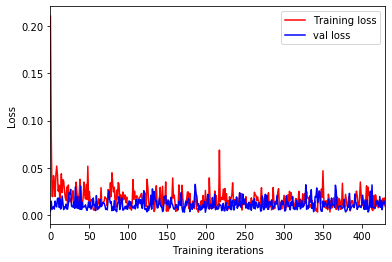

In [43]:
from matplotlib import pyplot as plt
plt.plot(range(len(loss_list)), loss_list,'r', label = "Training loss")
plt.plot(range(len(val_loss_list)), val_loss_list,'b', label = "val loss")

plt.xlabel("Training iterations")
plt.ylabel("Loss")
plt.xlim(0, 430)
plt.legend()
plt.show()



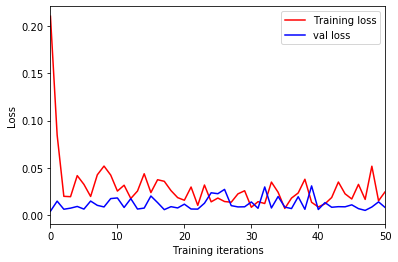

In [44]:
from matplotlib import pyplot as plt
plt.plot(range(len(loss_list)), loss_list,'r', label = "Training loss")
plt.plot(range(len(val_loss_list)), val_loss_list,'b', label = "val loss")

plt.xlabel("Training iterations")
plt.ylabel("Loss")
plt.xlim(0, 50)
plt.legend()
plt.show()

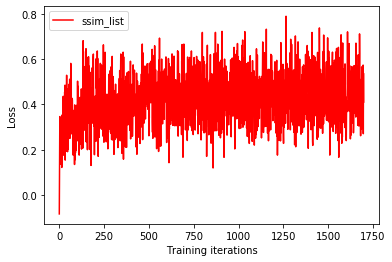

In [45]:
plt.plot(range(len(ssim_list)), ssim_list,'r', label = "ssim_list")
plt.xlabel("Training iterations")
plt.ylabel("Loss")
#plt.xlim(0, 50)
plt.legend()
plt.show()

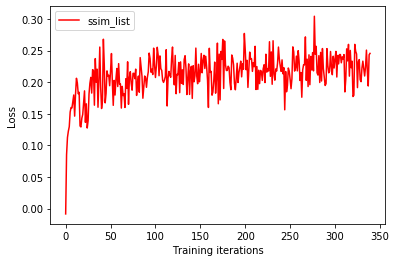

In [47]:
plt.plot(range(len(AV_batch_sim_list)), AV_batch_sim_list,'r', label = "ssim_list")
plt.xlabel("Training iterations")
plt.ylabel("Loss")
#plt.xlim(0, 50)
plt.legend()
plt.show()

In [ ]:
torch.save(model,"unet_model_save")